### Variable Scatter Plotter (Separated by Landuse)
A python script to plot a scatter plot for sensitivity analysis of one variable with landuse on each series, specifically made for urban area analysis.
#### How to Use
* Change the dictionary of `RUN_IDS` to the rural land use and corresponding id in `~/runs/` that you want to compare
* Change `INDEPENDENT_VAR` name to the independent (x-axis) variable that you want to compare. Please change this to match the set of `RUN_IDS` since I don't have a good way to know which variable you want to analyze.
* `ANALYZE_VARS` is the array that you can change the content to select which variable from WRF output to plot
* Now you can run the thing. Be careful of the variable dimensions. You can take a look inside the code to see where you should handle those

In [26]:
from netCDF4 import Dataset
from glob import glob
import numpy as np
from wrf import getvar, ALL_TIMES, extract_times
import math

In [27]:
def sky_view_factor(lp: float, lf: float) -> float:
    '''
    Calculation of sky view factor from build area fraction (lambda p)
    and frontal area index (lambda f). Code adapted from WRF's kanda_kawai_svf
    function
    '''
    hovl = lf * lp ** (-0.5) / (1. - lp ** 0.5)
    vloc = np.cos(np.arctan(2. * hovl)) * (2. - 4. / np.pi * np.arctan(np.cos(np.arctan(2. * hovl))))
    vmod = 0.1120 * lp * vloc - 0.4817 * lp + 0.0246 * vloc + 0.9570
    svf = vloc * vmod

    return svf

def get_independent_var_values(wrfinput: Dataset, var_name: str) -> float:
    if var_name == 'URB_AREA_RATIO':
        attrs = wrfinput.__dict__
        urban_mask = wrfinput.variables['LU_INDEX'][0] == attrs['ISURBAN']
        urban_size = math.floor(np.sqrt(np.sum(urban_mask)))
        rural_size = math.floor(np.sqrt(np.prod(urban_mask.shape) - np.sum(urban_mask)))

        return urban_size / rural_size
    elif var_name == 'SKY_VIEW_FACTOR':
        # Use build area fraction as reference, should have the same dim
        var_dimensions = wrfinput.variables['BUILD_AREA_FRACTION'].ndim
        lambda_p = wrfinput.variables['BUILD_AREA_FRACTION'][*(0 for _ in range(var_dimensions - 2)), 50, 50]
        lambda_f = wrfinput.variables['LF_URB2D_S'][*(0 for _ in range(var_dimensions - 2)), 50, 50]

        return sky_view_factor(lambda_p, lambda_f)

    var_dimensions = wrfinput.variables[var_name].ndim
    return wrfinput.variables[var_name][*(0 for _ in range(var_dimensions - 2)), 50, 50]

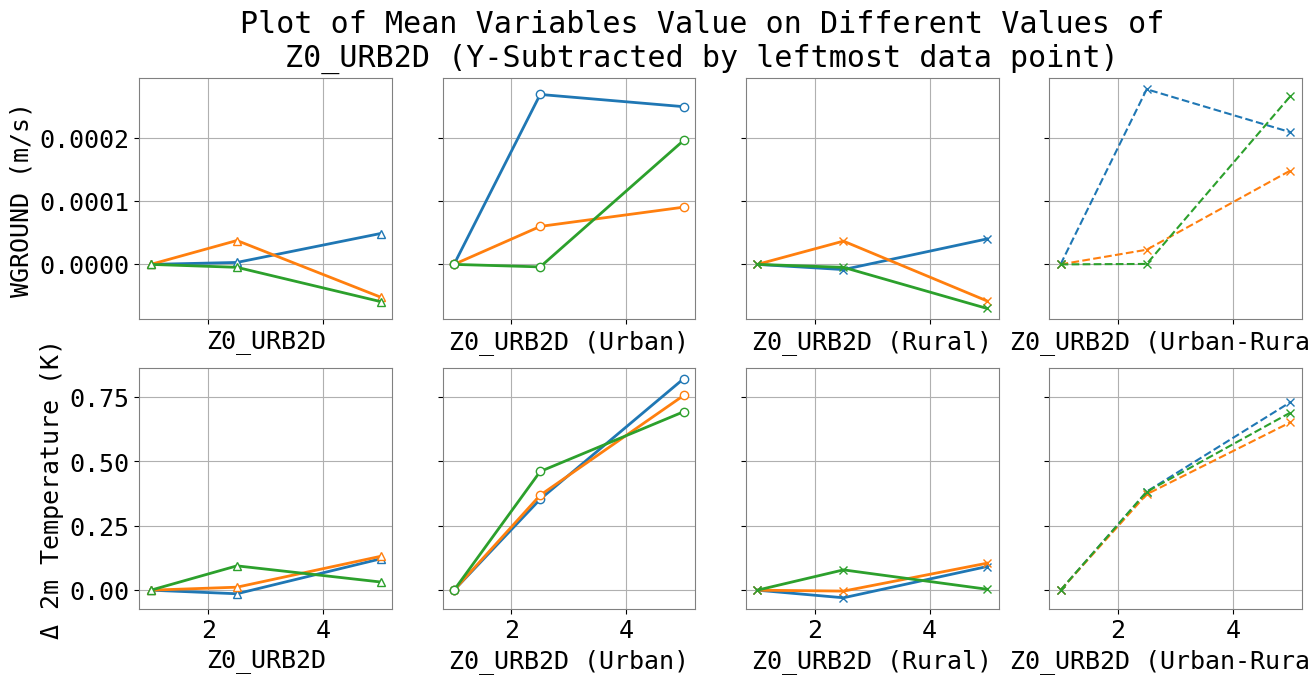

In [38]:
import matplotlib.pyplot as plt
from time import time

# All ids of the runs we want to plot, separated by series
# {
#     "Landuse 1": [LANDUSE1_RUN_ID_1, LANDUSE1_RUN_ID_2, ...],
#     "Landuse 2": [LANDUSE2_RUN_ID_1, LANDUSE2_RUN_ID_2, ...],
#     ... ,
# }
RUN_IDS = {
    # 'grassland':    [45, 46, 63],
    # 'barren':       [51, 52, 73],
    # 'forest':       [57, 58, 68],

    'grassland':    [45, 47, 64],
    'barren':       [51, 53, 74],
    'forest':       [57, 59, 69],

    # 'grassland':    [45, 48, 49, 65, 66],
    # 'barren':       [51, 54, 55, 75, 76],
    # 'forest':       [57, 60, 61, 70, 71],
}

# BUILD_AREA_FRACTION   BUILDING PLAN AREA DENSITY 
# BUILD_SURF_RATIO      BUILDING SURFACE AREA TO PLAN AREA RATIO
# BUILD_HEIGHT          AVERAGE BUILDING HEIGHT WEIGHTED BY BUILDING PLAN AREA
# MH_URB2D              Mean Building Height
# STDH_URB2D            Standard Deviation of Building Height
# LF_URB2D              Frontal Area Index
# Z0_URB2D              Roughness length for momentum
# LF_URB2D_S            Frontal area index (use this one for analysis)
# AHE                   Anthropogenic heat emission
# URB_AREA_RATIO        <Custom> Urban Area Size / Rural Area Size
# SKY_VIEW_FACTOR       <Custom> Sky view factor

INDEPENDENT_VAR = 'Z0_URB2D'

plt.rcParams['font.size'] = 18 
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

threshold_datetime = np.datetime64('2025-03-10')

times = []

# ANALYZE_VARS = ['T2', 'SPEED10', 'W', 'PBLH', 'CLDFRA', 'QRAIN', 'rh2', 'TSK', 'HFX']
ANALYZE_VARS = ['WGROUND', 'T2']
NUM_COLS = 4
fig, axes = plt.subplots(len(ANALYZE_VARS), NUM_COLS, figsize=(15, (31 / 9) * len(ANALYZE_VARS)), sharex=True, sharey='row')
# fig.tight_layout(pad=0.5)

dataset: Dataset = {}

for j, var_name in enumerate(ANALYZE_VARS):
    for rural_land_type in RUN_IDS.keys():
        print(f'Processing {var_name} of {rural_land_type}...' + (' ' * 40), end='\r')
        mean_var_values = []
        mean_var_values_urban = []
        mean_var_values_rural = []
        for i, run_id in enumerate(RUN_IDS[rural_land_type]):
            # Not optimal, but we aren't working with that many datasets anyways
            file_name = glob(f'/home/guc/runs/{run_id:03}-*/wrfout*')[0]
            wrfinput_name = glob(f'/home/guc/runs/{run_id:03}-*/wrfinput*')[0]
            dataset = Dataset(file_name)
            wrfinput = Dataset(wrfinput_name)

            # Initialize times array for extraction
            if len(times) == 0:
                times = extract_times(dataset, timeidx=ALL_TIMES)

            # Get wind speed instead of just U10 V10
            if var_name == 'SPEED10':
                u10 = getvar(dataset, 'U10', timeidx=ALL_TIMES)
                v10 = getvar(dataset, 'V10', timeidx=ALL_TIMES)
                var_values = np.sqrt(u10**2 + v10**2)
            elif var_name == 'WGROUND': 
                var_values = getvar(dataset, 'W', timeidx=ALL_TIMES)[:,:2,:,:]
            else: 
                var_values = getvar(dataset, var_name, timeidx=ALL_TIMES)

            if var_name == 'T2':
                var_values -= 273.15 # Convert to Celsius

            if var_name in ['W', 'WGROUND']:
                var_values -= np.abs(var_values) # Absolute value of vertical wind

            # Cut variables value by threshold (spin-up time)
            cut_var_value = []
            for time_idx, date_time in enumerate(times):
                if (date_time < threshold_datetime): continue
                cut_var_value.append(var_values[time_idx])
            cut_var_value = np.array(cut_var_value)

            # Urban mask
            wrf_input_attrs = wrfinput.__dict__
            urban_mask = wrfinput.variables['LU_INDEX'][0] == wrf_input_attrs['ISURBAN']
            rural_mask = wrfinput.variables['LU_INDEX'][0] != wrf_input_attrs['ISURBAN']

            # Sample from the middle assuming it's urban
            independent_var_value = get_independent_var_values(wrfinput, INDEPENDENT_VAR)

            mean_var_values.append((
                independent_var_value,
                np.mean(cut_var_value)
            ))
            mean_var_values_urban.append((
                independent_var_value,
                np.mean(cut_var_value[:, urban_mask]) if len(cut_var_value.shape) == 3
                else np.mean(cut_var_value[:, :, urban_mask])
            ))
            mean_var_values_rural.append((
                independent_var_value,
                np.mean(cut_var_value[:, rural_mask]) if len(cut_var_value.shape) == 3
                else np.mean(cut_var_value[:, :, rural_mask])
            ))

        # "Normalize" these values by subtracting from the lowest one
        mean_var_values.sort()
        x_values = np.array([x[0] for x in mean_var_values])
        y_values = np.array([x[1] - mean_var_values[0][1] for x in mean_var_values])

        mean_var_values_urban.sort()
        x_values_urb = np.array([x[0] for x in mean_var_values_urban])
        y_values_urb = np.array([x[1] - mean_var_values_urban[0][1] for x in mean_var_values_urban])

        mean_var_values_rural.sort()
        x_values_rural = np.array([x[0] for x in mean_var_values_rural])
        y_values_rural= np.array([x[1] - mean_var_values_rural[0][1] for x in mean_var_values_rural])

        axes[j][0].plot(x_values, y_values, '^-', mfc='white', label=f'{rural_land_type}', linewidth=2)
        axes[j][1].plot(x_values_urb, y_values_urb, 'o-', mfc='white', label=f'{rural_land_type}', linewidth=2)
        axes[j][2].plot(x_values_rural, y_values_rural, 'x-', mfc='white', label=f'{rural_land_type}', linewidth=2)
        axes[j][3].plot(x_values_rural, y_values_urb - y_values_rural, 'x--', mfc='white', label=f'{rural_land_type}')

    for ax_id in range(NUM_COLS):
        axes[j][ax_id].margins(0.05, 0.05)
        axes[j][ax_id].grid()
        # axes[j][ax_id].legend(prop={'size': 8})
    
    # Uppercase to handle wrf python convention, speed10 is defined by myself so it needs to be handled
    custom_var_unit = {
        'SPEED10': 'm/s',
        'rh2': '%',
        'CLDFRA': 'no unit',
        'T2': 'K',
        'WGROUND': 'm/s'
    }
    var_unit = dataset.variables[var_name].units if not var_name in custom_var_unit else custom_var_unit[var_name]

    custom_var_name = {
        'SPEED10': 'Δ Wind Speed\nat 10m',
        'QRAIN': 'Δ Water-Rain\nMixing Ratio',
        'rh2': 'Δ 2m Humidity\n',
        'T2': 'Δ 2m Temperature',
    }
    axes[j][0].set_ylabel(f'{var_name if var_name not in custom_var_name else custom_var_name[var_name]} ({var_unit})')
    axes[j][0].set_xlabel(f'{INDEPENDENT_VAR}')
    axes[j][1].set_xlabel(f'{INDEPENDENT_VAR} (Urban)')
    axes[j][2].set_xlabel(f'{INDEPENDENT_VAR} (Rural)')
    axes[j][3].set_xlabel(f'{INDEPENDENT_VAR} (Urban-Rural)')

for ax in axes:
    for j in range(NUM_COLS):
        plt.setp(ax[j].spines.values(), color="gray")

fig.suptitle(f'Plot of Mean Variables Value on Different Values of\n{INDEPENDENT_VAR} (Y-Subtracted by leftmost data point)')

plt.savefig(f'/home/guc/results/var-comparison/shifted-{INDEPENDENT_VAR}-wground-2.png')